In [0]:
import torch
from torchtext import data

import pandas as pd
import numpy as np
import torch.optim as optim
import torch.nn.functional as F

import spacy

import time
import copy
from torch.optim import lr_scheduler

from torchtext.vocab import Vectors, GloVe
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import plot, hist

import nltk

Let's look at our dataset:

In [2]:
df = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [0]:
headlines = df['headline'].str.lower().str.replace("[^a-z]", " ")

In [0]:
headlines = headlines.apply(lambda headline: headline.split())

In [5]:
nltk.download('stopwords')
from nltk.corpus import stopwords 
stop_words = stopwords.words('english')

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()

headlines = headlines.apply(lambda headline: [lem.lemmatize(word) for word in headline if word not in stop_words])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
detokenized_headlines = [] 
for i in range(len(headlines)): 
    t = ' '.join(headlines[i]) 
    detokenized_headlines.append(t) 

df['headline'] = detokenized_headlines

Counting number of headlines with appropriate number of words:

In [14]:
count = df['headline'].str.split().apply(len).value_counts()
print(count)

7      4887
8      4606
6      4251
9      3507
5      3240
10     2181
4      2031
11     1186
3      1096
12      584
2       481
13      290
14      132
15       55
1        53
16       14
17       11
18        4
24        2
19        2
0         2
22        1
30        1
25        1
107       1
Name: headline, dtype: int64


We can see, that most part of headlines has less then 18 words. We will use this fact for choosing length of sequence.

Dropping unusefull column:

In [15]:
df = df.drop(['article_link'], axis=1)
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientist unveil doomsday cloc...
1,0,dem rep totally nail congress falling short ge...
2,0,eat veggie deliciously different recipe
3,1,inclement weather prevents liar getting work
4,1,mother come pretty close using word streaming ...


We will use 20% of dataset as test set.

In [0]:
X = df['headline']
y = df['is_sarcastic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Loading test and train sets to csv:

In [0]:
!mkdir torchtext_data

In [0]:
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_data.to_csv("torchtext_data/train.csv", index=False)
test_data.to_csv("torchtext_data/test.csv", index=False)

Prepearing data:

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
fix_length = 18
TEXT = data.Field(sequential=True, tokenize="spacy", fix_length=fix_length)
LABEL = data.LabelField(dtype=torch.long, sequential=False)

In [0]:
train_data, test_data = data.TabularDataset.splits(
    path="torchtext_data/", train="train.csv", 
    test="test.csv",format="csv", skip_header=True, 
    fields=[('Text', TEXT), ('Label', LABEL)]
)

In [0]:
batch_size = 16

train_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, test_data), sort_key=lambda x: len(x.Text),
    batch_size=batch_size,
    device=device)

In [23]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 22895
Number of testing examples: 5724


Making vocabluary with GloVe with dimantion of 300:

In [24]:
TEXT.build_vocab(train_data, vectors=GloVe(name='6B', dim=300))
LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [06:26, 2.23MB/s]                           
100%|█████████▉| 399904/400000 [00:51<00:00, 7691.73it/s]

In [0]:
word_embeddings = TEXT.vocab.vectors
output_size = 2 #two classes
num_layers = 1
hidden_size = 64 #num of units in our NN
embedding_length = 300 #dim of GloVe vector
vocab_size = len(TEXT.vocab)

Defining the model:


*   Simple LSTM - LSTMClassifier class 
*   LSTM with Attanrion - AttantionLSTMClassifier class 
*   Bidirectional LSTM - BidirectionalLSTMClassifier class
*   Bidirectional LSTM with 2D MaxPool layer - LSTM2DMaxPoolClassifier class





In [0]:
from LSTM import *

In [0]:
model = LSTMClassifier(batch_size, output_size, hidden_size, vocab_size, embedding_length, num_layers, word_embeddings)

In [0]:
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=6.98397e-05)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.05)

In [0]:
model = model.to(device)
criterion = criterion.to(device)

In [0]:
dataiter_dict = {'train': train_iterator, 'val': test_iterator}
dataset_sizes = {'train':len(train_data), 'val':len(test_data)}

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    print('starting')
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 200

    val_loss = []
    train_loss = []
    val_acc = []
    train_acc = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            sentiment_corrects = 0
            tp = 0.0 # true positive
            tn = 0.0 # true negative
            fp = 0.0 # false positive
            fn = 0.0 # false negative

            # Iterate over data.
            for batch in dataiter_dict[phase]:
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    text = batch.Text
                    label = batch.Label
                    label = torch.autograd.Variable(label).long()

                    if torch.cuda.is_available():
                      text = text.cuda()
                      label = label.cuda()
                    if (batch.Text.size()[1] is not batch_size):
                      continue
                    
                    outputs = model(text)
                    outputs = F.softmax(outputs,dim=-1)                   
                    loss = criterion(outputs, label)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * text.size(0)
                sentiment_corrects += torch.sum(torch.max(outputs, 1)[1] == label)

                tp += torch.sum(torch.max(outputs, 1)[1] & label)
                tn += torch.sum(1-torch.max(outputs, 1)[1] & 1-label)
                fp += torch.sum(torch.max(outputs, 1)[1] & 1-label)
                fn += torch.sum(1-torch.max(outputs, 1)[1] & label)
                
            epoch_loss = running_loss / dataset_sizes[phase]
           
            sentiment_acc = float(sentiment_corrects) / dataset_sizes[phase]

            if phase == 'train':
                train_acc.append(sentiment_acc)
                train_loss.append(epoch_loss)
            elif phase == 'val':
                val_acc.append(sentiment_acc)
                val_loss.append(epoch_loss)

            print('{} total loss: {:.4f} '.format(phase,epoch_loss ))
            print('{} sentiment_acc: {:.4f}'.format(
                phase, sentiment_acc))

            if phase == 'val' and epoch_loss < best_loss:
                print('saving with loss of {}'.format(epoch_loss),
                      'improved over previous {}'.format(best_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'lstm_model_test.pth')

            if phase == 'val' and epoch == num_epochs - 1:
                recall = tp / (tp + fn)
                print('recall {:.2f}'.format(recall))

        print()

    confusion_matrix = [[float(tp), float(fp)],[float(fn), float(tn)]]
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(float(best_loss)))
    results = {'time': time_elapsed, 'recall': recall, 'conf_matr': confusion_matrix,
               'val_loss': val_loss, 'train_loss': train_loss, 'val_acc': val_acc, 'train_acc': train_acc}
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, results

Train model:

In [32]:
model_fit, res = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=8)

starting
Epoch 1/8
----------
train total loss: 0.7789 
train sentiment_acc: 0.5206
val total loss: 0.7782 
val sentiment_acc: 0.5231
saving with loss of 0.778203381120034 improved over previous 200

Epoch 2/8
----------
train total loss: 0.7289 
train sentiment_acc: 0.6063
val total loss: 0.6309 
val sentiment_acc: 0.7259
saving with loss of 0.630931629606013 improved over previous 0.778203381120034

Epoch 3/8
----------
train total loss: 0.5809 
train sentiment_acc: 0.7841
val total loss: 0.5834 
val sentiment_acc: 0.7776
saving with loss of 0.5833713948351782 improved over previous 0.630931629606013

Epoch 4/8
----------
train total loss: 0.5242 
train sentiment_acc: 0.8412
val total loss: 0.5841 
val sentiment_acc: 0.7799

Epoch 5/8
----------
train total loss: 0.4995 
train sentiment_acc: 0.8646
val total loss: 0.5939 
val sentiment_acc: 0.7715

Epoch 6/8
----------
train total loss: 0.4890 
train sentiment_acc: 0.8753
val total loss: 0.5876 
val sentiment_acc: 0.7797

Epoch 7/8
-

Lets see at test and train accuracy plots:

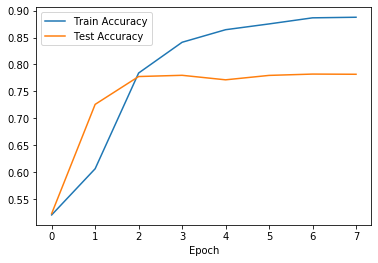

In [33]:
plt.plot(res['train_acc'], label = 'Train Accuracy')
plt.plot(res['val_acc'], label = 'Test Accuracy')
plt.xlabel('Epoch')
plt.legend()

And confusion matrix:

In [34]:
pd.DataFrame(res['conf_matr'])

,0,1
0,1922.0,441.0
1,796.0,2553.0
